In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
from inpainting.dataset import Data, ResizeTransform, ConditionSampler
from gan.conditional_gan import Generator5Net, Discriminator5
from gan.losses import GeneratorLoss, DiscriminatorLoss
from gan.trainer import ConditionalGanTrainer
from torch.utils.data import DataLoader 
from torch.utils.data.dataset import Subset
import torch
import matplotlib.pyplot as plt
import pandas as pd
from inpainting.visualize import plot_batch
from inpainting.visualize import cGanPlotLossCallback, ConditionDescriber
from inpainting import cond_celeba_config as conf
from inpainting.visualizer import Visualizer

%matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


Without the incoming socket you cannot receive events from the server or register event handlers to your Visdom client.


In [2]:
torch.cuda.set_device(conf.CUDA_DEVICE)

In [3]:

transform = ResizeTransform()
data = Data(conf.DATA_PATH, conf.Z_SIZE, transform, return_attr=True, conditions=conf.conditions)
y_sampler = ConditionSampler(data)
#data = Subset(data, range(100))
data_loader = DataLoader(data, batch_size=conf.BATCH_SIZE, num_workers=conf.NUM_WORKERS, shuffle=True)
print('Dataset size: ', len(data))
print('y size: ', conf.Y_SIZE)


Dataset size:  202599
y size:  5


[-1.  1. -1.  1. -1.]


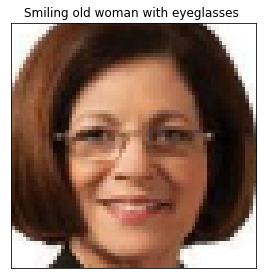

In [4]:
cd = ConditionDescriber(conf.conditions)
y = cd.create_y(Male=False, Smiling=True, Young=False, Eyeglasses=True)
#y = np.array([0, 1, 0, 0, 0])*2 - 1
idx = data.find_image(y)
img, z, y_new = data[idx]
print(y_new)
plot_batch([img], normalize=True, limit=1, descriptions=[cd.describe(y)])

In [5]:
generator = Generator5Net(conf.Z_SIZE, conf.Y_SIZE).cuda()
discriminator = Discriminator5(conf.Y_SIZE).cuda()

In [7]:
visualizer = Visualizer(conf.ENV_NAME, y_sampler)
trainer = ConditionalGanTrainer(generator, discriminator, conf, y_sampler, visualizer=visualizer)

In [8]:
if conf.CONTINUE_TRAINING:
    trainer.load_last_checkpoint()
    
trainer.train(data_loader, n_epochs=280)

Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f75fa0d7828>>
Traceback (most recent call last):
  File "/home/red-haired/programming/inpainting/venv/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/home/red-haired/programming/inpainting/venv/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 345, in get
    return ForkingPickler.loads(res)
  File "/home/red-haired/programming/inpainting/venv/lib/python3.5/site-packages/torch/multiprocessing/reductions.py", line 70, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.5/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/lib/python3.5/multiprocessing/reduction.py", line 181, in recv_handle
 

Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f75fa0e5f28>>
Traceback (most recent call last):
  File "/home/red-haired/programming/inpainting/venv/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/home/red-haired/programming/inpainting/venv/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 345, in get
    return ForkingPickler.loads(res)
  File "/home/red-haired/programming/inpainting/venv/lib/python3.5/site-packages/torch/multiprocessing/reductions.py", line 70, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.5/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/lib/python3.5/multiprocessing/reduction.py", line 181, in recv_handle
 

Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
U

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f75fa0f1e10>>
Traceback (most recent call last):
  File "/home/red-haired/programming/inpainting/venv/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/home/red-haired/programming/inpainting/venv/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 345, in get
    return ForkingPickler.loads(res)
  File "/home/red-haired/programming/inpainting/venv/lib/python3.5/site-packages/torch/multiprocessing/reductions.py", line 70, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.5/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/lib/python3.5/multiprocessing/reduction.py", line 181, in recv_handle
 

Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f75f9282e48>>
Traceback (most recent call last):
  File "/home/red-haired/programming/inpainting/venv/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/home/red-haired/programming/inpainting/venv/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 345, in get
    return ForkingPickler.loads(res)
  File "/home/red-haired/programming/inpainting/venv/lib/python3.5/site-packages/torch/multiprocessing/reductions.py", line 70, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.5/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/lib/python3.5/multiprocessing/reduction.py", line 181, in recv_handle
 

Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f75fa0f1518>>
Traceback (most recent call last):
  File "/home/red-haired/programming/inpainting/venv/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/home/red-haired/programming/inpainting/venv/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 345, in get
    return ForkingPickler.loads(res)
  File "/home/red-haired/programming/inpainting/venv/lib/python3.5/site-packages/torch/multiprocessing/reductions.py", line 70, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.5/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/lib/python3.5/multiprocessing/reduction.py", line 181, in recv_handle
 

Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f75f92825c0>>
Traceback (most recent call last):
  File "/home/red-haired/programming/inpainting/venv/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/home/red-haired/programming/inpainting/venv/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 345, in get
    return ForkingPickler.loads(res)
  File "/home/red-haired/programming/inpainting/venv/lib/python3.5/site-packages/torch/multiprocessing/reductions.py", line 70, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.5/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/lib/python3.5/multiprocessing/reduction.py", line 181, in recv_handle
 

Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
U

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f75f9282780>>
Traceback (most recent call last):
  File "/home/red-haired/programming/inpainting/venv/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/home/red-haired/programming/inpainting/venv/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 345, in get
    return ForkingPickler.loads(res)
  File "/home/red-haired/programming/inpainting/venv/lib/python3.5/site-packages/torch/multiprocessing/reductions.py", line 70, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.5/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/lib/python3.5/multiprocessing/reduction.py", line 181, in recv_handle
 

Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f75f9282748>>
Traceback (most recent call last):
  File "/home/red-haired/programming/inpainting/venv/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/home/red-haired/programming/inpainting/venv/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 345, in get
    return ForkingPickler.loads(res)
  File "/home/red-haired/programming/inpainting/venv/lib/python3.5/site-packages/torch/multiprocessing/reductions.py", line 70, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.5/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/lib/python3.5/multiprocessing/reduction.py", line 181, in recv_handle
 

Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f75f9282048>>
Traceback (most recent call last):
  File "/home/red-haired/programming/inpainting/venv/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/home/red-haired/programming/inpainting/venv/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 345, in get
    return ForkingPickler.loads(res)
  File "/home/red-haired/programming/inpainting/venv/lib/python3.5/site-packages/torch/multiprocessing/reductions.py", line 70, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.5/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/lib/python3.5/multiprocessing/reduction.py", line 181, in recv_handle
 

Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
U

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f75f9a96550>>
Traceback (most recent call last):
  File "/home/red-haired/programming/inpainting/venv/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/home/red-haired/programming/inpainting/venv/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 345, in get
    return ForkingPickler.loads(res)
  File "/home/red-haired/programming/inpainting/venv/lib/python3.5/site-packages/torch/multiprocessing/reductions.py", line 70, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.5/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.5/multiprocessing/resource_sharer.py",

Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results


In [8]:
LOAD_MODEL = True
LOAD_EPOCH_N = 2
if LOAD_MODEL:
    generator.load_state_dict(torch.load(conf.MODEL_PATH + 'generator_%d.pth' % (LOAD_EPOCH_N,)))
    discriminator.load_state_dict(torch.load(conf.MODEL_PATH + 'discriminator_%d.pth' % (LOAD_EPOCH_N,)))
    generator.eval()
    discriminator.eval()

Without the incoming socket you cannot receive events from the server or register event handlers to your Visdom client.


In [9]:

visualizer.update_losses(2., 7., type='validation')
visualizer.update_losses(4., 8., type='validation')
visualizer.update_losses(6., 9., type='validation')

<class 'numpy.dtype'>
D_real:  0.1876756250858307 D_fake:  0.5620287656784058
D_logit_real:  -1.4651846885681152 D_logit_fake:  0.24939975142478943
Discriminator loss:  1.1577470302581787
1.0378236770629883


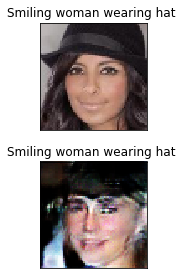

In [25]:
scalar = lambda v: np.asscalar(v.data.cpu().numpy())

Z = torch.normal(mean=torch.zeros(1, generator.z_size)).cuda()
        # 'Male', 'Smiling', 'Young', 'Eyeglasses', 'Wearing_Hat'
y = cd.create_y(Male=False, Smiling=True, Young=True, Eyeglasses=False, Wearing_Hat=True)
print(dtype)
idx = data.find_image(y)
img, z, y_new = data[idx]
X = torch.tensor([img]).cuda()
y = y.astype(np.float32)
Y = torch.tensor([
                  y]).cuda()

G_sample = generator(Z, Y)
D_real, D_logit_real = discriminator(X, Y)
D_fake, D_logit_fake = discriminator(G_sample, Y)

generator_loss = GeneratorLoss()
discriminator_loss = DiscriminatorLoss(label_smoothing=0.25)

print("D_real: ", scalar(D_real), "D_fake: ", scalar(D_fake))
print("D_logit_real: ", scalar(D_logit_real), "D_logit_fake: ", scalar(D_logit_fake))

d_loss = discriminator_loss(D_logit_real, D_logit_fake)

print("Discriminator loss: ", scalar(d_loss))
print(scalar(discriminator_loss(torch.tensor([10.0]).cuda(), D_logit_fake)))
sample = np.concatenate((img[None, :, :, :], G_sample.data.cpu().numpy()))
plot_batch(sample, normalize=True, descriptions=[cd.describe(y)]*2)

In [26]:
w = discriminator.layer4.weight.data.cpu().numpy()
print(w.shape)
print(w[:, 0:5])
print(w[:, 5:])

AttributeError: 'Sequential' object has no attribute 'weight'